In [281]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

In [358]:
def get_all():
    fpath = '../congress-data/members/'
    files = os.listdir(fpath)
    house = set()
    senate = set()
    dem = set()
    rep = set()
    men = set()
    women = set()
    leaders = set()
    
    for file in files:
        df = pd.read_csv(fpath+file, index_col=0)
        print(file)
        mem_id = df.loc[0]['id']
        
        if df.loc[0]['gender'] == 'F':
            women.add(mem_id)
        else:
            men.add(mem_id)
            
        if len(df['chamber'].unique()) > 1:
            house.add(mem_id)
            senate.add(mem_id)
        elif df.loc[0]['chamber'].lower() == 'house':
            house.add(mem_id)
        else:
            senate.add(mem_id)
            
        if len(df['party'].unique()) > 1:
            rep.add(mem_id)
            dem.add(mem_id)
        elif df.loc[0]['party'] == 'D':
            dem.add(mem_id)
        else:
            rep.add(mem_id)
            
        for role in df['leadership_role']:
            if type(role) == str:
                leaders.add(df.loc[0]['id'])
                continue

    return house, senate, dem, rep, men, women, leaders

def get_ids(chamber, start_con, end_con, party=None):
    fpath = '../congress-data/members/'
    files = os.listdir(fpath)
    id_set = set()
    for file in files:
        df = pd.read_csv(fpath+file, index_col=0)
        
        sessions = df['congress'].values
        
        first_con = min(sessions)
        last_con = max(sessions)
        
        if first_con > end_con or last_con < start_con:
            continue
            
        if party != None:
            if (len(df['party'].unique()) > 1) or (df.loc[0]['party'] == party):
                id_set.add(df.loc[0]['id'])
                continue
        
        if (len(df['chamber'].unique()) > 1) or (df.loc[0]['chamber'].lower() == chamber):
            id_set.add(df.loc[0]['id'])
                
    return id_set

def get_csv(mem_id, to_drop):
    fpath = '../congress-data/members/'
    df = pd.read_csv(fpath+mem_id+'.csv', index_col=0)
    
    df.dropna(subset=to_drop, inplace=True)
    return df

In [259]:
(house, senate, dem, rep, men, women, leaders) = get_all()

H001033.csv
J000232.csv
B000410.csv
R000608.csv
W000798.csv
R000146.csv
S001171.csv
L000180.csv
C000705.csv
H000463.csv
C000077.csv
S001165.csv
G000580.csv
M001148.csv
G000557.csv
M001174.csv
M001160.csv
G000225.csv
R000191.csv
K000319.csv
S000051.csv
B000160.csv
A000356.csv
H000675.csv
B001256.csv
B001242.csv
R000436.csv
L000396.csv
F000440.csv
T000035.csv
F000454.csv
F000332.csv
D000563.csv
T000009.csv
B001295.csv
B001281.csv
O000163.csv
F000468.csv
S000125.csv
C001037.csv
H000729.csv
B000982.csv
S000119.csv
L000590.csv
S001207.csv
P000449.csv
H000067.csv
B000028.csv
L000584.csv
S001213.csv
B000996.csv
J000187.csv
E000064.csv
D000359.csv
R000595.csv
M001202.csv
K000292.csv
L000553.csv
G000153.csv
R000581.csv
W000808.csv
E000299.csv
G000386.csv
W000820.csv
D000629.csv
W000607.csv
D000615.csv
M001014.csv
D000601.csv
D000600.csv
D000614.csv
T000356.csv
M000445.csv
D000628.csv
T000424.csv
W000821.csv
B001135.csv
C000116.csv
R000033.csv
S001004.csv
E000298.csv
H000502.csv
A000009.csv
C000

N000016.csv
J000287.csv
J000293.csv
N000002.csv
H001079.csv
H000367.csv
C000773.csv
C000767.csv
B001036.csv
S001113.csv
H001045.csv
H001051.csv
S001139.csv
H001047.csv
H001053.csv
P000005.csv
F000187.csv
H000365.csv
J000285.csv
T000243.csv
H001090.csv
J000291.csv
M000236.csv
S000596.csv
K000190.csv
M001100.csv
L000123.csv
P000575.csv
B000666.csv
K000379.csv
C001123.csv
W000288.csv
C000567.csv
R000442.csv
H000615.csv
B001236.csv
F000434.csv
C000598.csv
J000093.csv
D000259.csv
R000495.csv
K000392.csv
G000047.csv
K000386.csv
R000481.csv
L000321.csv
L000447.csv
O000088.csv
C001043.csv
P000373.csv
M000183.csv
C001057.csv
R000536.csv
C001080.csv
W000465.csv
E000004.csv
C001094.csv
S000810.csv
B001168.csv
P000603.csv
P000617.csv
P000171.csv
S000409.csv
R000046.csv
T000445.csv
F000030.csv
C000836.csv
M000342.csv
L000043.csv
T000479.csv
T000478.csv
D000106.csv
T000322.csv
W000672.csv
C000189.csv
C000823.csv
W000666.csv
G000481.csv
R000053.csv
A000069.csv
P000616.csv
P000170.csv
A000055.csv
S000

S001136.csv
S001122.csv
S000214.csv
H001074.csv
G000289.csv
K000148.csv
I000057.csv
H001060.csv
M001127.csv
N000033.csv
K000362.csv
R000465.csv
Y000065.csv
R000317.csv
K000376.csv
R000459.csv
S000770.csv
E000194.csv
P000546.csv
S000016.csv
C001110.csv
B001239.csv
P000552.csv
F000349.csv
P000585.csv
P000591.csv
K000389.csv
R000277.csv
M000826.csv
C001058.csv
B000709.csv
C001070.csv
C001064.csv
V000025.csv
S000189.csv
C000385.csv
F000215.csv
E000037.csv
H000975.csv
B001167.csv
P000618.csv
H000236.csv
N000190.csv
J000301.csv
N000184.csv
C000178.csv
L000070.csv
U000005.csv
W000654.csv
T000462.csv
T000476.csv
N000147.csv
U000039.csv
T000477.csv
U000038.csv
B000287.csv
T000463.csv
G000465.csv
H000586.csv
B000536.csv
N000185.csv
W000682.csv
N000191.csv
S000407.csv
J000300.csv
H000237.csv
B001172.csv
M001085.csv
T000113.csv
M000628.csv
B000913.csv
L000267.csv
H000948.csv
D000451.csv
S000822.csv
C001065.csv
C001071.csv
C001059.csv
R000262.csv
M000199.csv
S000639.csv
H000747.csv
D000492.csv
P000

S000672.csv
A000207.csv
C001006.csv
P000444.csv
M000878.csv
R000229.csv
L000589.csv
A000213.csv
W000391.csv
R000567.csv
J000149.csv
M000688.csv
M000844.csv
B001307.csv
K000274.csv
R000573.csv
Q000023.csv
B001298.csv
T000010.csv
F000465.csv
V000127.csv
O000146.csv
C000293.csv
T000038.csv
F000459.csv
V000133.csv
K000328.csv
A000373.csv
B000145.csv
B000151.csv
A000367.csv
B000179.csv
B001267.csv
R000361.csv
B001273.csv
Y000013.csv
D000585.csv
B000384.csv
N000051.csv
P000097.csv
M001179.csv
G000566.csv
D000036.csv
S001183.csv
M001145.csv
M001151.csv
S001197.csv
G000572.csv
W000795.csv
S000510.csv
S001168.csv
H001016.csv
W000781.csv
C000052.csv
R000611.csv
R000605.csv
M001192.csv
H000452.csv
H000334.csv
S001154.csv


### Basic Stats

In [269]:
def missed_votes_5_num_sum(group_1, group_2, grouping, g1_filter, g2_filter, ylim):
    g1_missed_votes = []
    g2_missed_votes = []
    
    for mem_id in group_1:
        df = get_csv(mem_id, to_drop=['gender', 'total_votes', 
                  'missed_votes'])
        if len(df) == 0:
            continue
        
        df = df[df[grouping] == g1_filter]
        g1_missed_votes.extend(df['missed_votes'])
        
    for mem_id in group_2:
        df = get_csv(mem_id, to_drop=['gender', 'total_votes', 
                  'missed_votes'])
        if len(df) == 0:
            continue
        
        df = df[df[grouping] == g2_filter]
        g2_missed_votes.extend(df['missed_votes'])
        
    g1_quartiles = np.percentile(g1_missed_votes, [25, 50, 75])
    g2_quartiles = np.percentile(g2_missed_votes, [25, 50, 75])
    
    g1_min = np.min(g1_missed_votes)
    g1_max = np.max(g1_missed_votes)
    
    g2_min = np.min(g2_missed_votes)
    g2_max = np.max(g2_missed_votes)
    
    
    print('Comparing: %s' % (grouping))
    print('    | %s | %s |' % (g1_filter, g2_filter))
    print('Min:| %d | %d |' % (g1_min, g2_min))
    print('Q1: | %d | %d |' % (g1_quartiles[0], g2_quartiles[0]))
    print('Med:| %d | %d |' % (g1_quartiles[1], g2_quartiles[1]))
    print('Q3: | %d | %d |' % (g1_quartiles[2], g2_quartiles[2]))
    print('Max:| %d | %d |' % (g1_max, g2_max))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    sns.boxenplot(g1_missed_votes, ax=ax[0], orient='v')
    sns.boxenplot(g2_missed_votes, ax=ax[1], orient='v')


    #ax[0].boxplot(g1_missed_votes)
    #ax[1].boxplot(g2_missed_votes)
    ax[0].set_title('%s Missed Votes' % g1_filter)
    ax[1].set_title('%s Missed Votes' % g2_filter)
    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)

Comparing: party
    | D | R |
Min:| 0 | 0 |
Q1: | 13 | 12 |
Med:| 32 | 26 |
Q3: | 66 | 52 |
Max:| 1695 | 1594 |


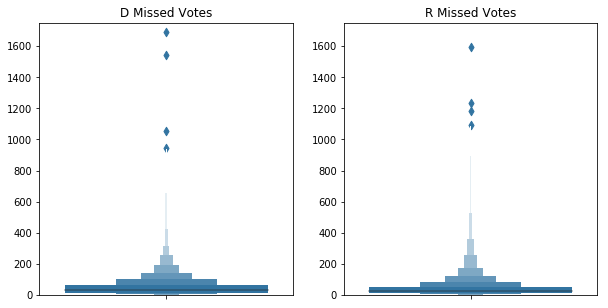

In [270]:
missed_votes_5_num_sum(dem, rep, 'party', 'D', 'R', ylim=(0, 1750))

We see that Democrats tend to have a slightly higher amount of missed votes than Republicans:

```
Comparing: party
    | D    | R    |
----+------+------+
Min:| 0    | 0    |
Q1: | 13   | 12   |
Med:| 32   | 26   |
Q3: | 66   | 52   |
Max:| 1695 | 1594 |
```

Comparing: gender
    | M | F |
Min:| 0 | 0 |
Q1: | 12 | 11 |
Med:| 28 | 32 |
Q3: | 58 | 65 |
Max:| 1594 | 1695 |


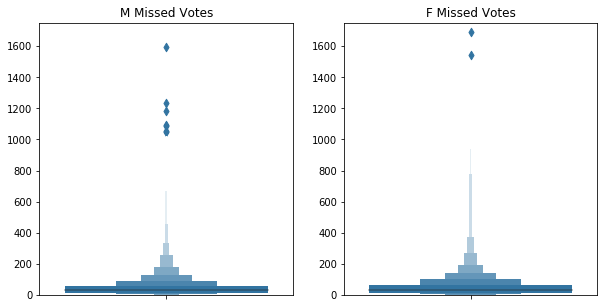

In [271]:
missed_votes_5_num_sum(men, women, 'gender', 'M', 'F', ylim=(0, 1750))


We see that women tend to have a slightly higher amount of missed votes than men:
```
Comparing: gender
    | M    | F    |
----+------+------+
Min:| 0    | 0    |
Q1: | 12   | 11   |
Med:| 28   | 32   |
Q3: | 58   | 65   |
Max:| 1594 | 1695 |
```

In [272]:
def sort_leaders(leaders):
    house_leaders = set()
    senate_leaders = set()
    for leader_id in leaders:
        mem_df = get_csv(leader_id, to_drop=['total_votes', 'missed_votes'])
        
        for idx, row in mem_df.iterrows():
            if row['chamber'] == 'House' and type(row['leadership_role']) == str:
                house_leaders.add(row['id'])
            elif row['chamber'] == 'Senate' and type(row['leadership_role']) == str:
                senate_leaders.add(row['id'])
    return house_leaders, senate_leaders
        
def leaders_5_num_sum(chamber_set, leaders, chamber, ylim):
    non_leader_missed_votes = []
    leader_missed_votes = []
    
    for mem_id in chamber_set:
        df = get_csv(mem_id, to_drop=['total_votes', 'missed_votes'])
        if len(df) == 0:
            continue
        
        df = df[df['chamber'] == chamber]
        df = df[df['leadership_role'].isnull()]
        non_leader_missed_votes.extend(df['missed_votes'])
        
    for mem_id in leaders:
        df = get_csv(mem_id, to_drop=['total_votes', 'missed_votes'])
        if len(df) == 0:
            continue
        
        df = df[df['chamber'] == chamber]
        df = df[~df['leadership_role'].isnull()]
        leader_missed_votes.extend(df['missed_votes'])
                
    non_leader_quartiles = np.percentile(non_leader_missed_votes, [25, 50, 75])
    leader_quartiles = np.percentile(leader_missed_votes, [25, 50, 75])
    
    non_leader_min = np.min(non_leader_missed_votes)
    non_leader_max = np.max(non_leader_missed_votes)
    
    leader_min = np.min(leader_missed_votes)
    leader_max = np.max(leader_missed_votes)
    
    
    print('Comparing: Leadership')
    print('    | Non-Leaders | Leaders |')
    print('Min:| %d | %d |' % (non_leader_min, leader_min))
    print('Q1: | %d | %d |' % (non_leader_quartiles[0], leader_quartiles[0]))
    print('Med:| %d | %d |' % (non_leader_quartiles[1], leader_quartiles[1]))
    print('Q3: | %d | %d |' % (non_leader_quartiles[2], leader_quartiles[2]))
    print('Max:| %d | %d |' % (non_leader_max, leader_max))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    sns.boxenplot(non_leader_missed_votes, ax=ax[0], orient='v')
    sns.boxenplot(leader_missed_votes, ax=ax[1], orient='v')

    ax[0].set_title('Non-Leader Missed Votes - %s' % chamber)
    ax[1].set_title('Leader Missed Votes - %s' % chamber)
    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)

In [273]:
house_leaders, senate_leaders = sort_leaders(leaders)

Comparing: Leadership
    | Non-Leaders | Leaders |
Min:| 0 | 0 |
Q1: | 16 | 28 |
Med:| 34 | 53 |
Q3: | 65 | 119 |
Max:| 947 | 1695 |


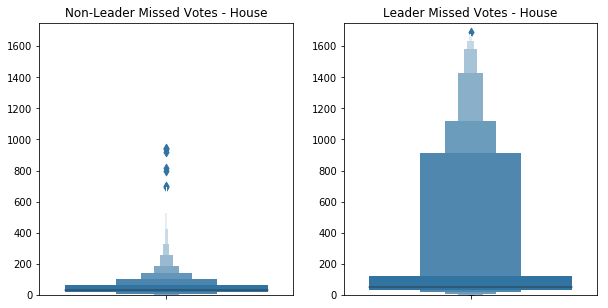

In [274]:
leaders_5_num_sum(house, house_leaders, 'House', ylim=(0,1750))

Comparing: Leadership
    | Non-Leaders | Leaders |
Min:| 0 | 0 |
Q1: | 5 | 1 |
Med:| 11 | 4 |
Q3: | 22 | 10 |
Max:| 488 | 201 |


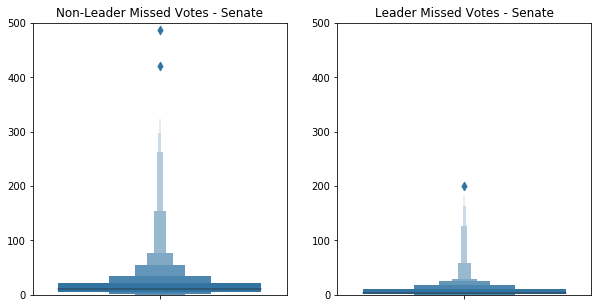

In [275]:
leaders_5_num_sum(senate, senate_leaders, 'Senate', ylim=(0,500))

### Plotting leaders' total missed votes over time

In [336]:
def plot_leaders(leader_ids, leader_roles):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    roles_added = set()
    blue_added = False
    red_added = False
    for leader_id in leader_ids:
        df = get_csv(leader_id, to_drop=['total_votes', 'missed_votes'])
        
        missed_votes = df['missed_votes']
        congress = df['congress']
        
        party = df['party'][0]
        if party == 'D':
            c = '#64B5F6'
            label = 'Democrat' if not blue_added else ''
            blue_added = True
        else:
            c = '#E57373'
            label = 'Republican' if not red_added else ''
            red_added = True
        
        ax.plot(congress, missed_votes, c=c, linewidth=1, label=label)
        
        for role in leader_roles:
            if role == 'Speaker of the House':
                c_ = '#7570b3'
                label_ = role if role not in roles_added else ''
                roles_added.add(role)
            elif role == 'Majority Lead':
                c_ = '#1b9e77'
                label_ = role if role not in roles_added else ''
                roles_added.add(role)
            elif role == 'Majority Whip':
                c_ = '#d95f02'
                label_ = role if role not in roles_added else ''
                roles_added.add(role)
            elif role == 'Minority Lead':
                c_ = '#66a61e'
                label_ = role if role not in roles_added else ''
                roles_added.add(role)
            elif role == 'Minority Whip':
                c_ = '#e6ab02'
                label_ = role if role not in roles_added else ''
                roles_added.add(role)
            else:
                c_ = 'grey'
                label_ = role if role not in roles_added else ''
                roles_added.add(role)
            
            role_missed = df[df['leadership_role'] == role]['missed_votes']
            role_session = df[df['leadership_role'] == role]['congress']
            
            ax.scatter(role_session, role_missed, c=c_, s=50, label=label_, edgecolor='black')
            
    ax.legend()  

In [278]:
def get_roles(leaders):
    house_roles = set()
    senate_roles = set()
    for ids in leaders:
        df = get_csv(ids, to_drop=['total_votes', 'missed_votes'])
        df = df[~df['leadership_role'].isnull()]

        for idx, row in df.iterrows():
            if row['chamber'] == 'House':
                house_roles.add(row['leadership_role'])
            else:
                senate_roles.add(row['leadership_role'])
    return house_roles, senate_roles

In [331]:
def get_ids_by_role(leaders, role):
    id_set = set()
    for ids in leaders:
        df = get_csv(ids, to_drop=['total_votes', 'missed_votes'])
        df = df[df['leadership_role'].isin(role)]
        
        if len(df) > 0:
            id_set.add(df['id'].values[0])
            
    return id_set

In [338]:
house_roles, senate_roles = get_roles(leaders)

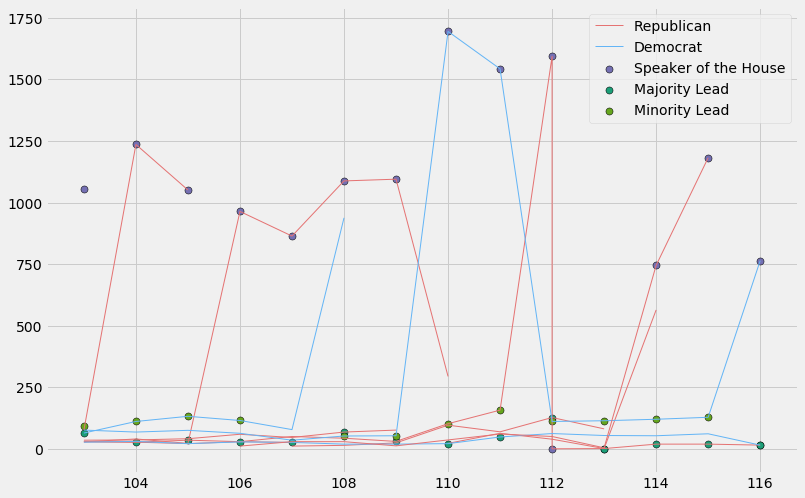

In [339]:
roles = ['Speaker of the House', 'Majority Lead', 'Minority Lead']
ids = get_ids_by_role(house_leaders, roles)
plot_leaders(ids, roles)

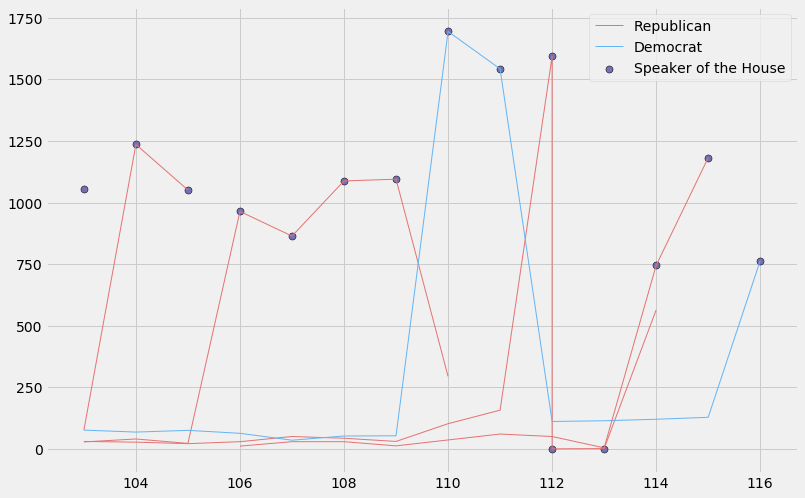

In [341]:
roles = ['Speaker of the House']
ids = get_ids_by_role(house_leaders, roles)
plot_leaders(ids, roles)

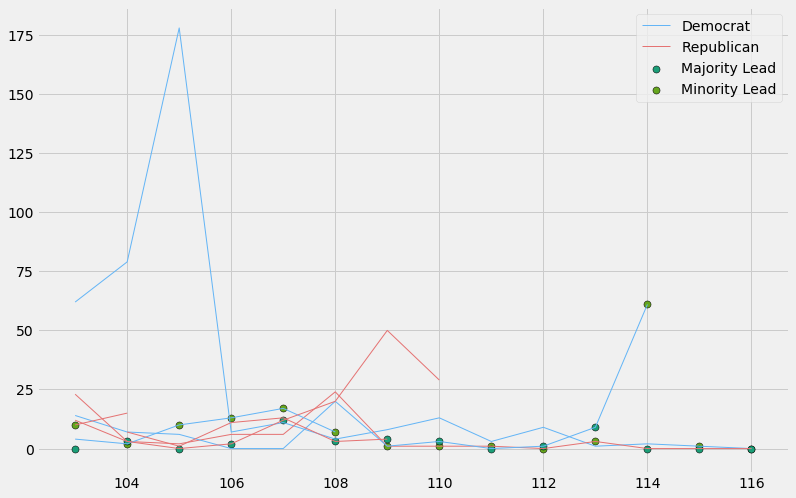

In [340]:
roles = ['Majority Lead', 'Minority Lead']
ids = get_ids_by_role(senate_leaders, roles)
plot_leaders(ids, roles)

### Need to look at committees now lol


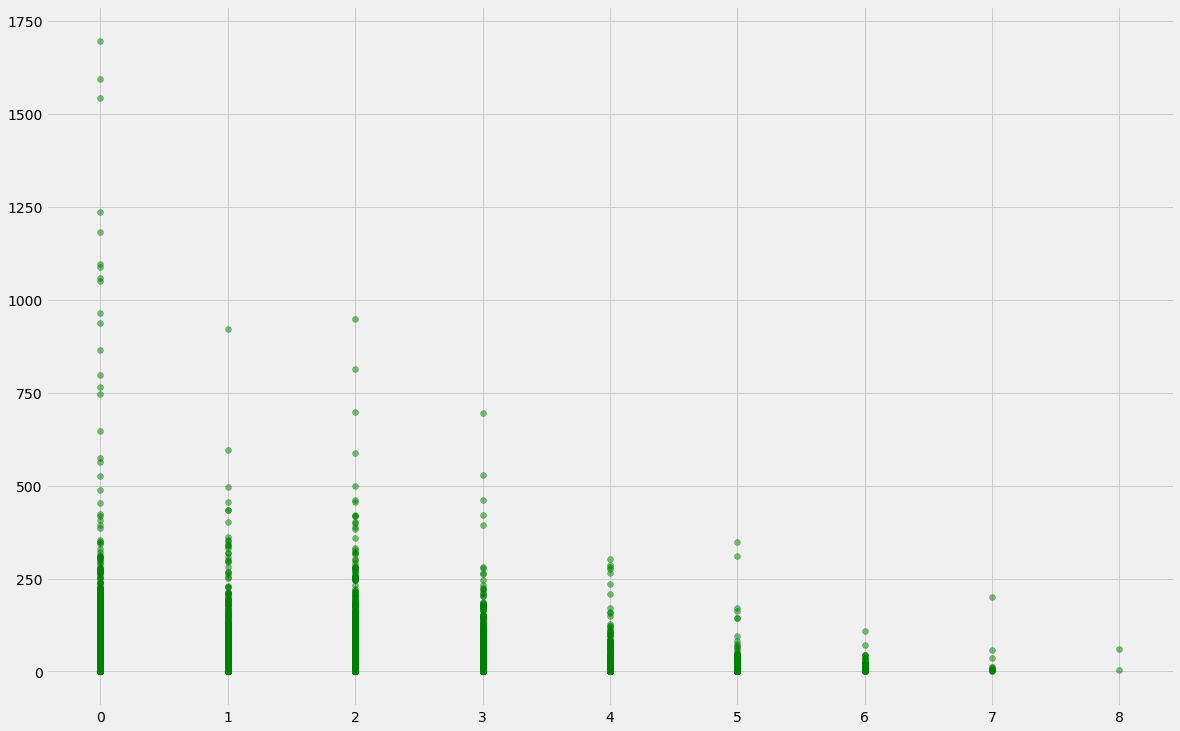

In [361]:
fig, ax = plt.subplots(figsize=(18,12))
for member in house:
    df = get_csv(member, to_drop=['total_votes', 'missed_votes', 'subcommittees', 'committees'])
    missed_votes = df['missed_votes']
    committees = df['committees']
    
    ax.scatter(committees, missed_votes, c='green', alpha=0.5)

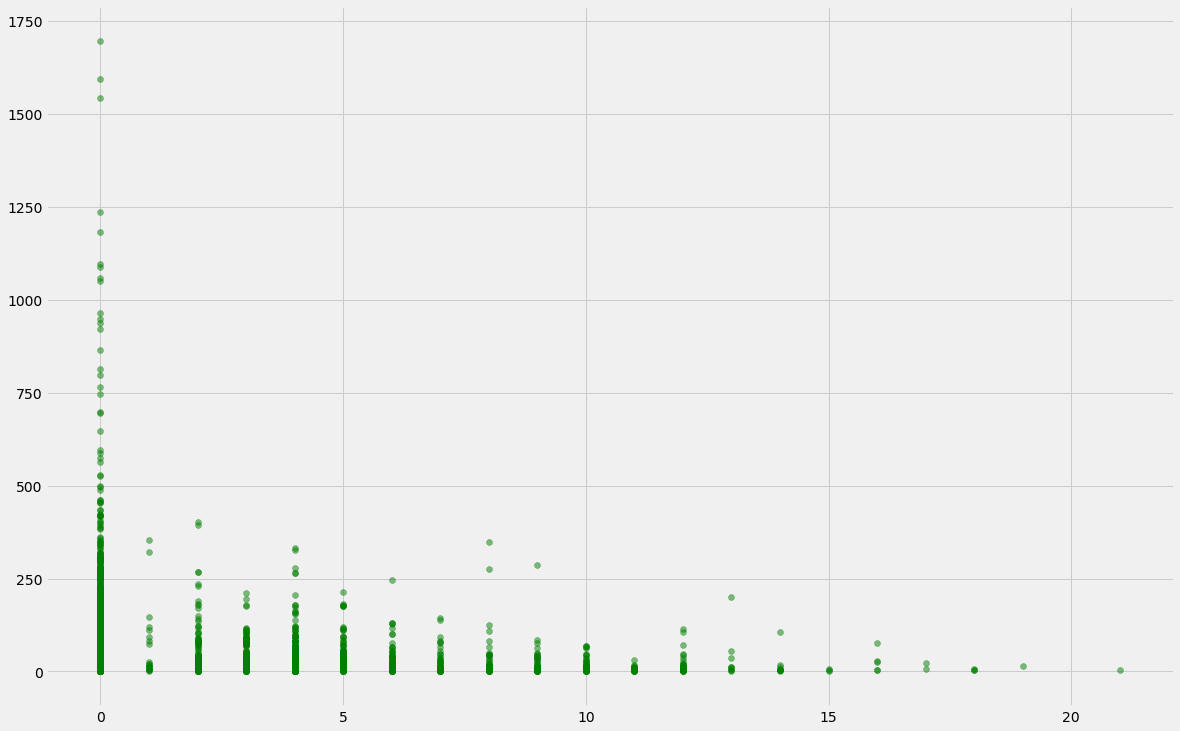

In [363]:
fig, ax = plt.subplots(figsize=(18,12))
for member in house:
    df = get_csv(member, to_drop=['total_votes', 'missed_votes', 'subcommittees', 'committees'])
    missed_votes = df['missed_votes']
    committees = df['subcommittees']
    
    ax.scatter(committees, missed_votes, c='green', alpha=0.5)

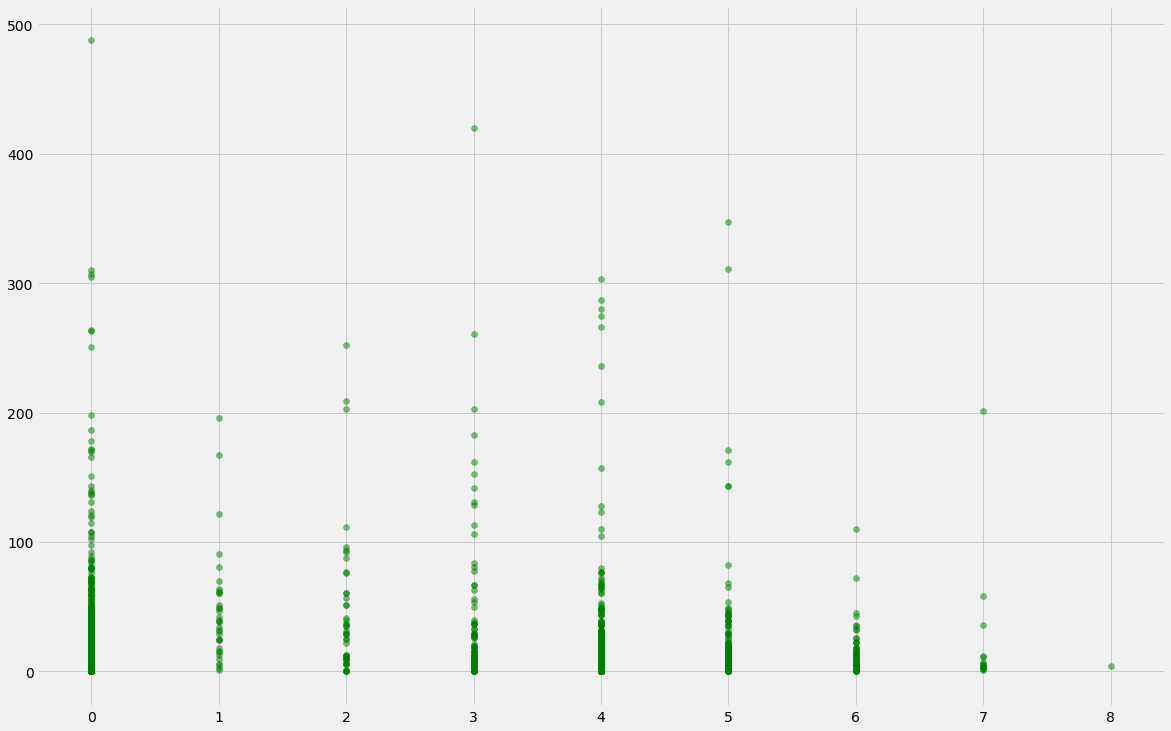

In [365]:
fig, ax = plt.subplots(figsize=(18,12))
for member in senate:
    df = get_csv(member, to_drop=['total_votes', 'missed_votes', 'subcommittees', 'committees'])
    missed_votes = df['missed_votes']
    committees = df['committees']
    
    ax.scatter(committees, missed_votes, c='green', alpha=0.5)

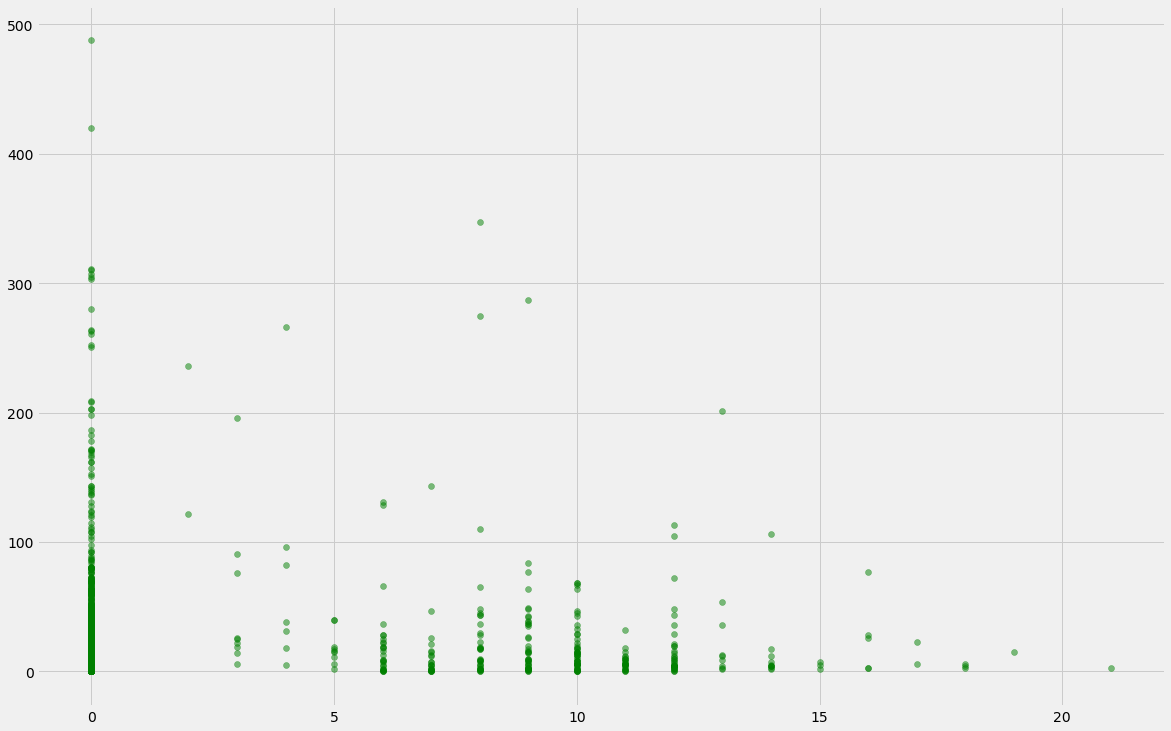

In [366]:
fig, ax = plt.subplots(figsize=(18,12))
for member in senate:
    df = get_csv(member, to_drop=['total_votes', 'missed_votes', 'subcommittees', 'committees'])
    missed_votes = df['missed_votes']
    committees = df['subcommittees']
    
    ax.scatter(committees, missed_votes, c='green', alpha=0.5)